<img src="https://www.alura.com.br/artigos/assets/para-que-serve-adobe-illustrator/imagem1.jpg" alt="Imagem1.png" width="300" />


# **Redes Neurais Difusoras: Deep Learning com Pytorch**
---



## **Aula 03 - Codificando o Processo Forward**


Na aula anterior, vocês exploraram os fundamentos do processo de difusão, entenderam o papel do ruído e da entropia, e viram como tudo isso está ligado à capacidade do modelo de aprender uma distribuição complexa.

Agora é hora de **partir para a prática** e implementar o *forward process* passo a passo, desde o carregamento do dataset, passando pela definição do scheduler para os valores de $\beta_t$, até o cálculo do mecanismo $q(x_t|x_0)$ que adiciona o ruído de forma controlada.

Ao final, vamos:

- Visualizar como a **média** e o **desvio padrão** evoluem ao longo da difusão.
- Comparar **histogramas** dos dados em diferentes timesteps para entender como o processo se espalha.

In [ ]:
# Bibliotecas padrão
import math
import numpy as np
import textwrap
import random
import kagglehub
import shutil
import os
import pandas as pd

# Bibliotecas de visualização
import matplotlib.pyplot as plt
from PIL import Image

# Bibliotecas PyTorch, torchvision e estatisticas
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from scipy.stats import norm

device = "cuda" if torch.cuda.is_available() else "cpu"

## **Carregando o dataset**

Para treinar nosso modelo, vamos começar com um dataset simples. Escolhi o [Pixel Art](https://www.kaggle.com/datasets/ebrahimelgazar/pixel-art) do Kaggle, pois ele é leve e, ao mesmo tempo, visualmente interessante para demonstrar o processo de difusão.

Vamos baixá-lo, copiá-lo para o ambiente do Colab e deixar tudo pronto para uso.

In [ ]:
# Baixar dataset
dataset_path = kagglehub.dataset_download("ebrahimelgazar/pixel-art")

# Definir destino no /content
destination_path = '/content/pixel-art'

# Copiar para /content
shutil.copytree(dataset_path, destination_path, dirs_exist_ok=True)

print("Dataset copiado para:", destination_path)

100%|██████████| 85.7M/85.7M [00:05<00:00, 16.9MB/s]

Extracting files...


Dataset copiado para: /content/pixel-art


## **Preparando nosso Dataset e DataLoader**

Na sequência, vamos definir nossa classe `PixelArtDataset`, que herda de `torch.utils.data.Dataset`. Essa classe será responsável por carregar as imagens do dataset, ler o CSV com as labels e convertê-las para o formato adequado. Além disso, ela aplicará todas as transformações necessárias: normalizar os pixels para o intervalo [-1,1], redimensionar as imagens para a resolução desejada e transformá-las em tensores PyTorch. Dessa forma, deixamos os dados prontos para serem utilizados no treinamento do nosso modelo.

In [ ]:
class PixelArtDataset(Dataset):
    def __init__(self, images_dir, captions_file=None, transform=None):
        self.transform = transform
        self.captions = {}

        # Buscar todas as imagens recursivamente na pasta
        self.image_files = []
        for root, _, files in os.walk(images_dir):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                    self.image_files.append(os.path.join(root, file))

        # Se tiver um arquivo CSV com rótulos, carrega no dicionário
        if captions_file:
            df = pd.read_csv(captions_file)
            self.captions = {
                self.force_extension(os.path.basename(path).lower(), ".png"):
                    np.fromstring(label.strip("[]"), sep=" ").tolist()
                for path, label in zip(df['Image Path'], df['Label'])
            }

    def __len__(self):
        return len(self.image_files)

    def force_extension(self, filename, ext=".png"):
        return os.path.splitext(filename)[0] + ext

    def __getitem__(self, idx):
        # Recupera caminho e nome da imagem
        img_path = self.image_files[idx]
        img_name = os.path.basename(img_path).lower()
        img_name = self.force_extension(img_name, ".png")

        # Abre a imagem e converte para RGB
        image = Image.open(img_path).convert('RGB')

        # Aplica transformações caso existam
        if self.transform:
            image = self.transform(image)

        # Recupera o label do dicionário, se existir. Senão preenche com zeros
        label = self.captions.get(img_name, [0.0]*5)

        # Retorna dict com a imagem e o tensor do label
        return {
            "image": image,
            "label": torch.tensor(label, dtype=torch.float32)
        }

### **Dataset e Transform**

In [ ]:
# Transformação básica para normalizar para [-1,1]
transform = transforms.Compose([
    transforms.Resize((16, 16)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

## **Preparando dataset e DataLoader**

In [ ]:
# Dataset e DataLoader
dataset = PixelArtDataset(
    "/content/pixel-art/images",
    captions_file="/content/pixel-art/labels.csv",
    transform=transform
)

# Carrega dataset
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
print(len(dataset))

89400


### **Visualizando amostras do dataset**

Visualizando 16 amostras do dataset


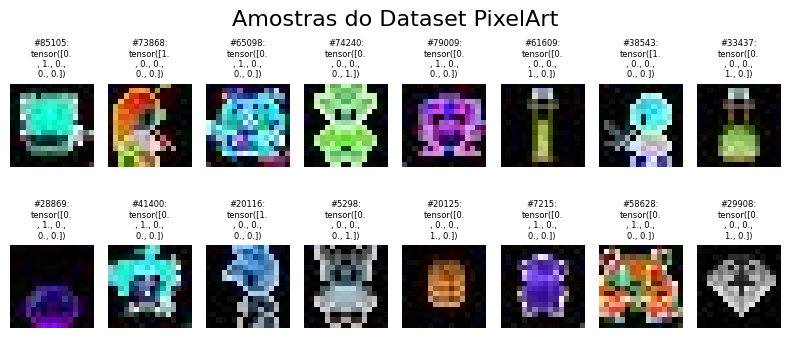

In [ ]:
# Seleciona aleatoriamente até 16 índices do dataset
indices = np.random.choice(len(dataset), size=min(16, len(dataset)), replace=False)
print(f"Visualizando {len(indices)} amostras do dataset")

# Define grid para exibição: 8 colunas e número de linhas necessário
cols = 8
rows = (len(indices) + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(8, 2 * rows))

# Garante que axes tenha sempre shape 2D para facilitar o loop
axes = np.atleast_2d(axes)

# Itera sobre cada índice selecionado e plota no grid
for i, idx in enumerate(indices):
    row, col = divmod(i, cols)
    ax = axes[row, col]

    sample = dataset[idx]

    # Recupera imagem e label
    image = sample['image']
    label = sample['label']

    # Desnormaliza de [-1,1] para [0,1]
    img_vis = torch.clamp((image * 0.5) + 0.5, 0, 1)
    img_np = img_vis.permute(1, 2, 0).cpu().numpy()

    # Plota a imagem
    ax.imshow(img_np)
    ax.axis('off')

    # Formata o texto do label em múltiplas linhas
    label = "\n".join(textwrap.wrap(str(label), width=10))
    ax.set_title(f"#{idx}:\n{label}", fontsize=6, pad=5)

# Oculta subplots vazios
total_slots = rows * cols
for i in range(len(indices), total_slots):
    row, col = divmod(i, cols)
    axes[row, col].axis('off')

# Título geral do grid
plt.suptitle("Amostras do Dataset PixelArt", fontsize=16, y=0.95)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

## **Scheduler de β: definindo o processo forward**

Agora chegamos à parte mais importante desta aula.

Primeiro, vamos criar a função `beta_schedule`, responsável por gerar o vetor de $\beta_t$ que controla quão rápido o ruído é adicionado ao longo dos timesteps.

Em seguida, implementaremos a classe `DiffusionForward`, que encapsula todo o processo forward da difusão, utilizando a forma fechada $q(x_t|x_0)$. Por fim, vamos adicionar a função `extract`, que facilita a manipulação dos tensores e garante o broadcasting correto durante as operações.


In [ ]:
def beta_schedule(timesteps: int, schedule: str = "cosine"):
    if schedule == "linear":
        return torch.linspace(1e-4, 0.02, timesteps)
    elif schedule == "cosine":  # baseado em Nichol & Dhariwal 2021
        s = 0.008
        steps = torch.arange(timesteps + 1, dtype=torch.float32)
        alphas_cumprod = torch.cos(
            ((steps / timesteps) + s) / (1 + s) * math.pi * 0.5
        ) ** 2
        alphas_cumprod /= alphas_cumprod[0].clone()  # normaliza para começar em 1
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        return torch.clip(betas, 0.0001, 0.999)
    else:
        raise ValueError("unknown schedule")

# Função extract para extrair valores do vetor ᾱₜ para x_t.
def extract(a, t, x_shape):
    out = a.gather(-1, t).float()
    return out.view(-1, *([1] * (len(x_shape) - 1)))

## **Classe do processo forward**

In [ ]:
class DiffusionForward:
    def __init__(self, timesteps: int = 1000, schedule="cosine", device="cpu"):
        # Inicializa o processo de difusão
        self.device = device
        self.timesteps = timesteps

        # Gera o cronograma de betas
        betas = beta_schedule(timesteps, schedule).to(device)

        # Registra todos os termos derivados
        self.register(betas)

    def register(self, betas):
        # Calcula valores auxiliares a partir dos betas
        self.betas = betas
        self.alphas = 1.0 - betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - self.alphas_cumprod)

    @torch.no_grad()
    def q_sample(self, x0, t, noise=None):
        # Amostra x_t dado x_0 no passo t adicionando ruído
        if noise is None:
            noise = torch.randn_like(x0)
        sqrt_a = extract(self.sqrt_alphas_cumprod, t, x0.shape)
        sqrt_m1_a = extract(self.sqrt_one_minus_alphas_cumprod, t, x0.shape)
        return sqrt_a * x0 + sqrt_m1_a * noise, noise


## **Visualizando a evolução do processo forward**

Por fim, vamos executar o processo forward em algumas amostras aleatórias
do dataset, plotando grids das imagens e também histogramas detalhados para
observar como a média e o desvio padrão evoluem ao longo do tempo.

Isso fecha a parte prática da Aula 03. Na próxima aula vamos focar no processo
reverse e começar a arquitetar o nosso modelo neural que vai aprender a inverter
o ruído para reconstruir as imagens originais.

In [ ]:
# Visualizar imagens em um grid por step
def plot_grid_normalizado(imgs_vis, steps, idx, label):
    grid = make_grid(torch.cat(imgs_vis), nrow=len(steps))
    plt.figure(figsize=(10,3))
    plt.imshow(grid.permute(1,2,0))
    plt.axis("off")
    plt.title(f"Forward Process para amostra #{idx}: {label}")
    plt.show()

# Visualizar histograms imagens em um grid por step
def plot_histogramas_paralelos(imgs_raw, imgs_vis_np, steps, idx):
    n_cols = len(steps)
    fig, axes = plt.subplots(2, n_cols, figsize=(3*n_cols, 6))

    for i, (img_arr_raw, img_arr_vis, t, ax_raw, ax_vis) in enumerate(zip(
            imgs_raw, imgs_vis_np, steps, axes[0], axes[1])):

        # Histograma dos valores reais
        data_raw = img_arr_raw.flatten()
        count, bins, ignored = ax_raw.hist(
            data_raw, bins=50, density=True,
            color='lightcoral', edgecolor='black', alpha=0.7
        )
        mu_raw, std_raw = norm.fit(data_raw)
        x = np.linspace(min(data_raw), max(data_raw), 100)
        p = norm.pdf(x, mu_raw, std_raw)
        ax_raw.plot(x, p, 'k', linewidth=2)
        ax_raw.set_title(f"RAW t={t}\nμ={mu_raw:.2f}, σ={std_raw:.2f}")
        ax_raw.set_xlabel("Pixel (float)")
        ax_raw.set_ylabel("Densidade")
        ax_raw.grid(True, linestyle="--", alpha=0.4)

        # Histograma dos valores normalizados para [0,1]
        data_vis = img_arr_vis.flatten()
        count, bins, ignored = ax_vis.hist(
            data_vis, bins=50, density=True,
            color='skyblue', edgecolor='black', alpha=0.7
        )
        mu_vis, std_vis = norm.fit(data_vis)
        x_vis = np.linspace(0, 1, 100)
        p_vis = norm.pdf(x_vis, mu_vis, std_vis)
        ax_vis.plot(x_vis, p_vis, 'r', linewidth=2)
        ax_vis.set_title(f"NORM t={t}\nμ={mu_vis:.2f}, σ={std_vis:.2f}")
        ax_vis.set_xlabel("Pixel (0-1)")
        ax_vis.set_ylabel("Densidade")
        ax_vis.grid(True, linestyle="--", alpha=0.4)

    plt.suptitle(f"Histogramas e Ajuste Normal por timestep\n(amostra #{idx})", fontsize=14, y=1.03)
    plt.tight_layout()
    plt.show()

#  Visualizar evolução da média e desvio padrão por step
def plot_evolucao_mean_std(steps, means, stds, idx):
    plt.figure(figsize=(8,4))
    plt.plot(steps, means, marker='o', label='Mean')
    plt.plot(steps, stds, marker='s', label='Std')
    plt.xlabel('Timestep')
    plt.ylabel('Valor')
    plt.title(f"Evolução μ e σ no processo forward (RAW) - amostra #{idx}")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.show()


In [ ]:
# Função para visualizacao e aplicação das funções
def plot_list(dataset, indices, pipe, graphs=False):
    for idx in indices:
        sample = dataset[idx]
        x0 = sample["image"].unsqueeze(0).to(device)

        imgs_vis = []
        imgs_vis_np = []
        imgs_raw = []
        means = []
        stds = []

        # Executa para cada timestep definido
        for t in steps:
            t_tensor = torch.tensor([t], device=device)
            xt, _ = pipe.q_sample(x0, t_tensor)

            means.append(xt.mean().item())
            stds.append(xt.std().item())

            xt_cpu_raw = xt.cpu().squeeze(0).permute(1,2,0).numpy()
            imgs_raw.append(xt_cpu_raw)

            xt_vis = (xt.cpu() * 0.5 + 0.5).clamp(0,1)
            imgs_vis.append(xt_vis)
            imgs_vis_np.append(xt_vis.squeeze(0).permute(1,2,0).numpy())

        label = sample["label"]

        # Escolhe o tipo de visualização
        if graphs:
            plot_histogramas_paralelos(imgs_raw, imgs_vis_np, steps, idx)
            plot_evolucao_mean_std(steps, means, stds, idx)
        else:
            plot_grid_normalizado(imgs_vis, steps, idx, label)


## **Executando tudo**

In [ ]:
steps = [0, 100, 250, 400, 600, 700, 999]

nsamples = 5
indices = random.sample(range(len(dataset)), k=min(nsamples, len(dataset)))
print(indices)

[63188, 75710, 25388, 75390, 46087]


#### **Executando com $\beta$ schedule linear**

In [ ]:
# Executando Forward
pipe = DiffusionForward(timesteps=1000, schedule='linear', device=device)

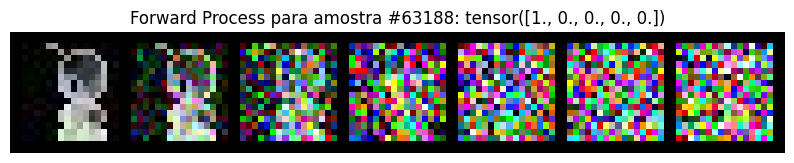

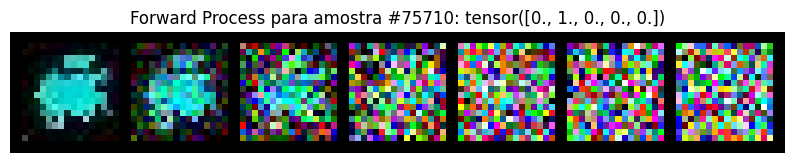

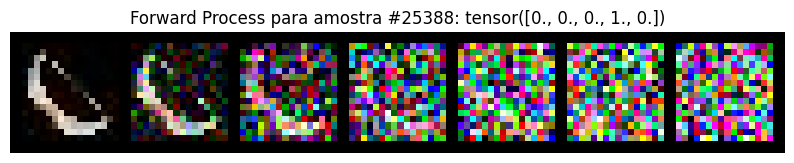

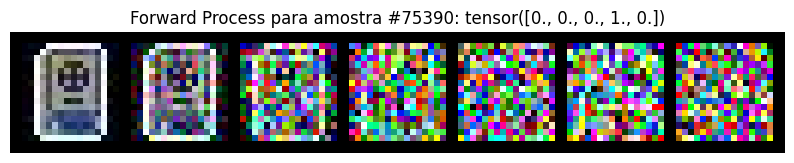

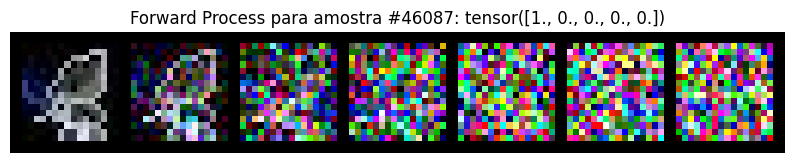

In [ ]:
# Mostrar Forward process de imagens aleatórias
plot_list(dataset, indices, pipe, graphs= False)

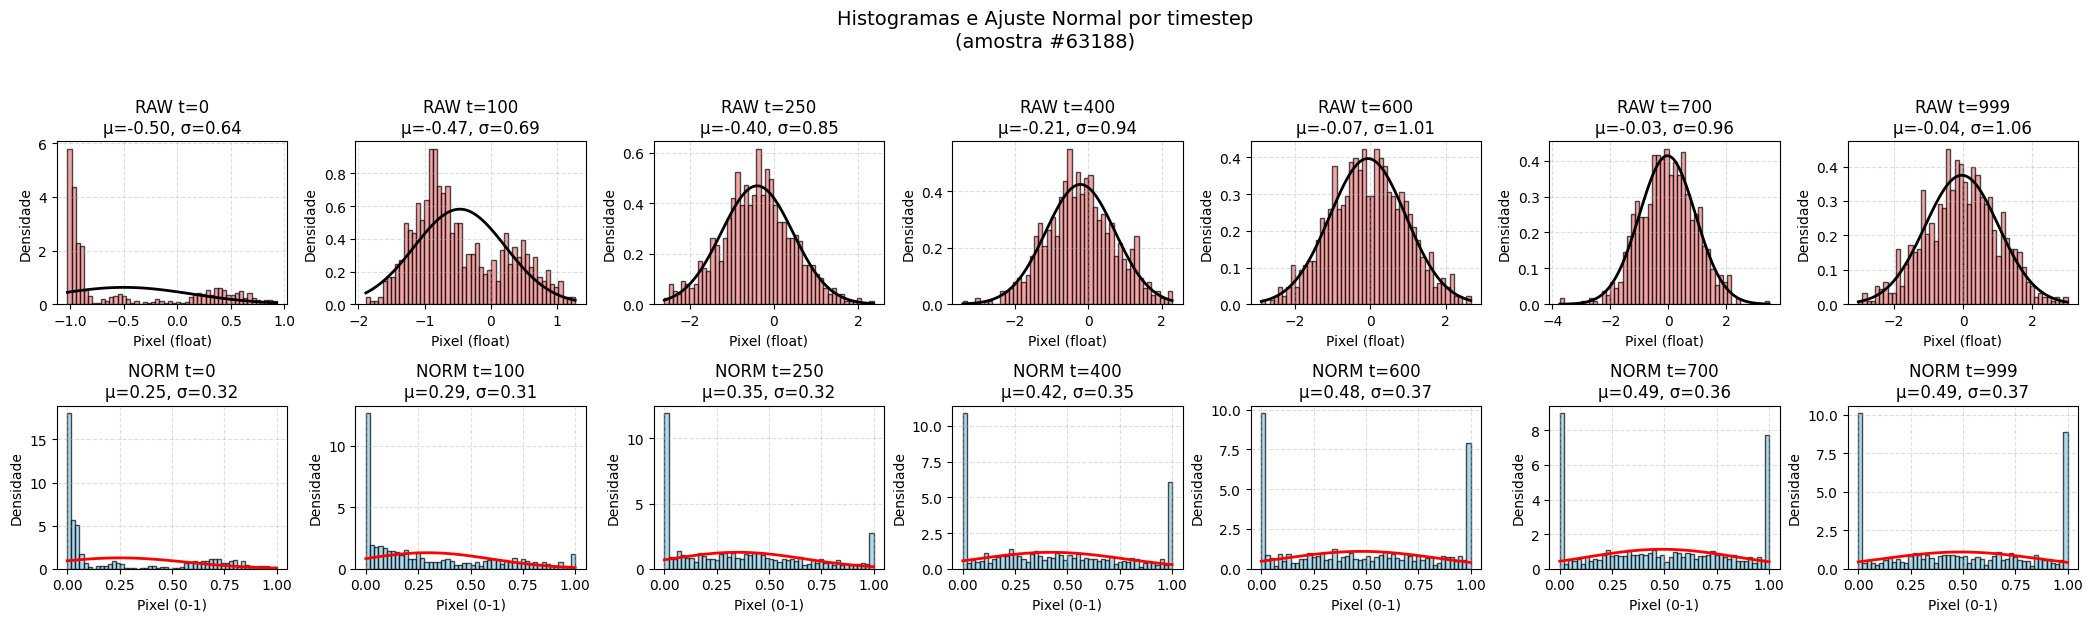

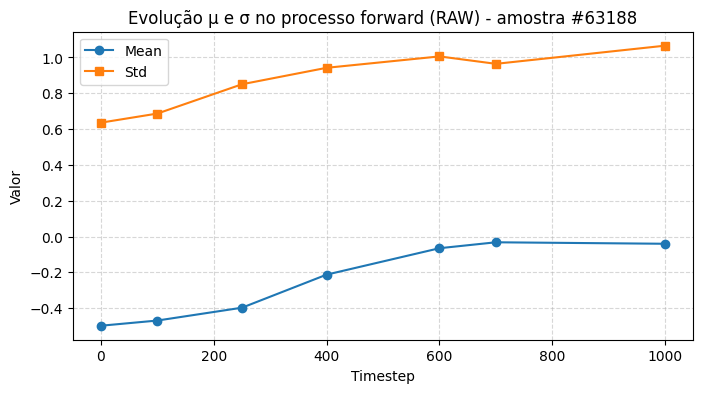

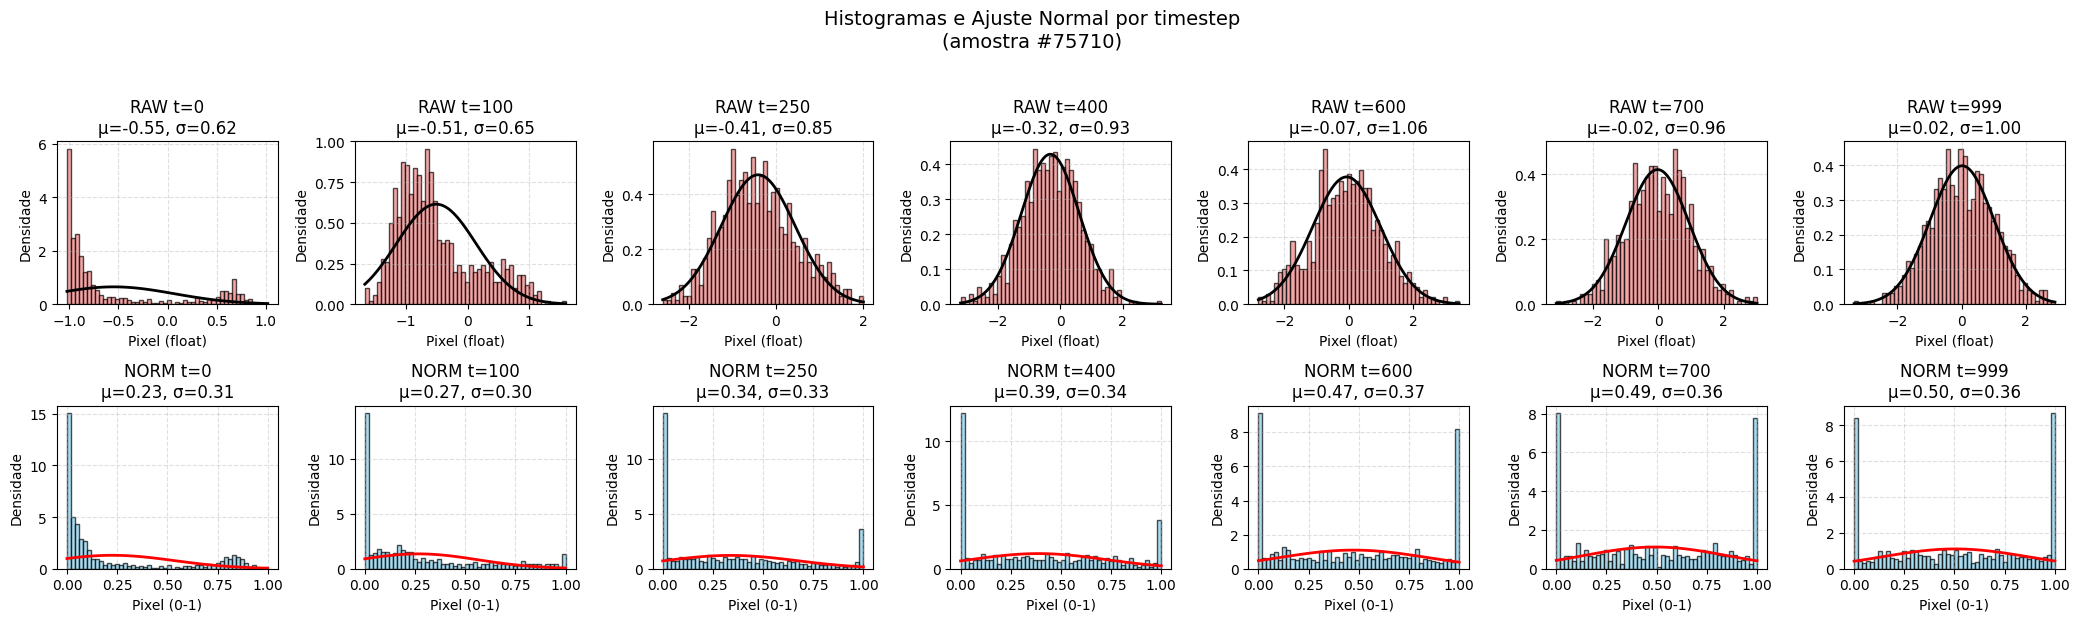

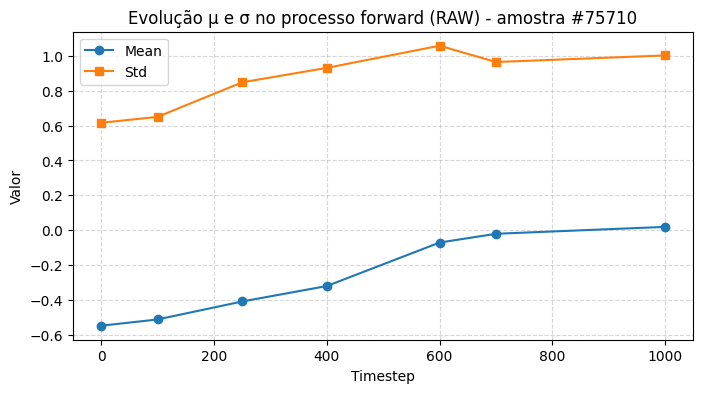

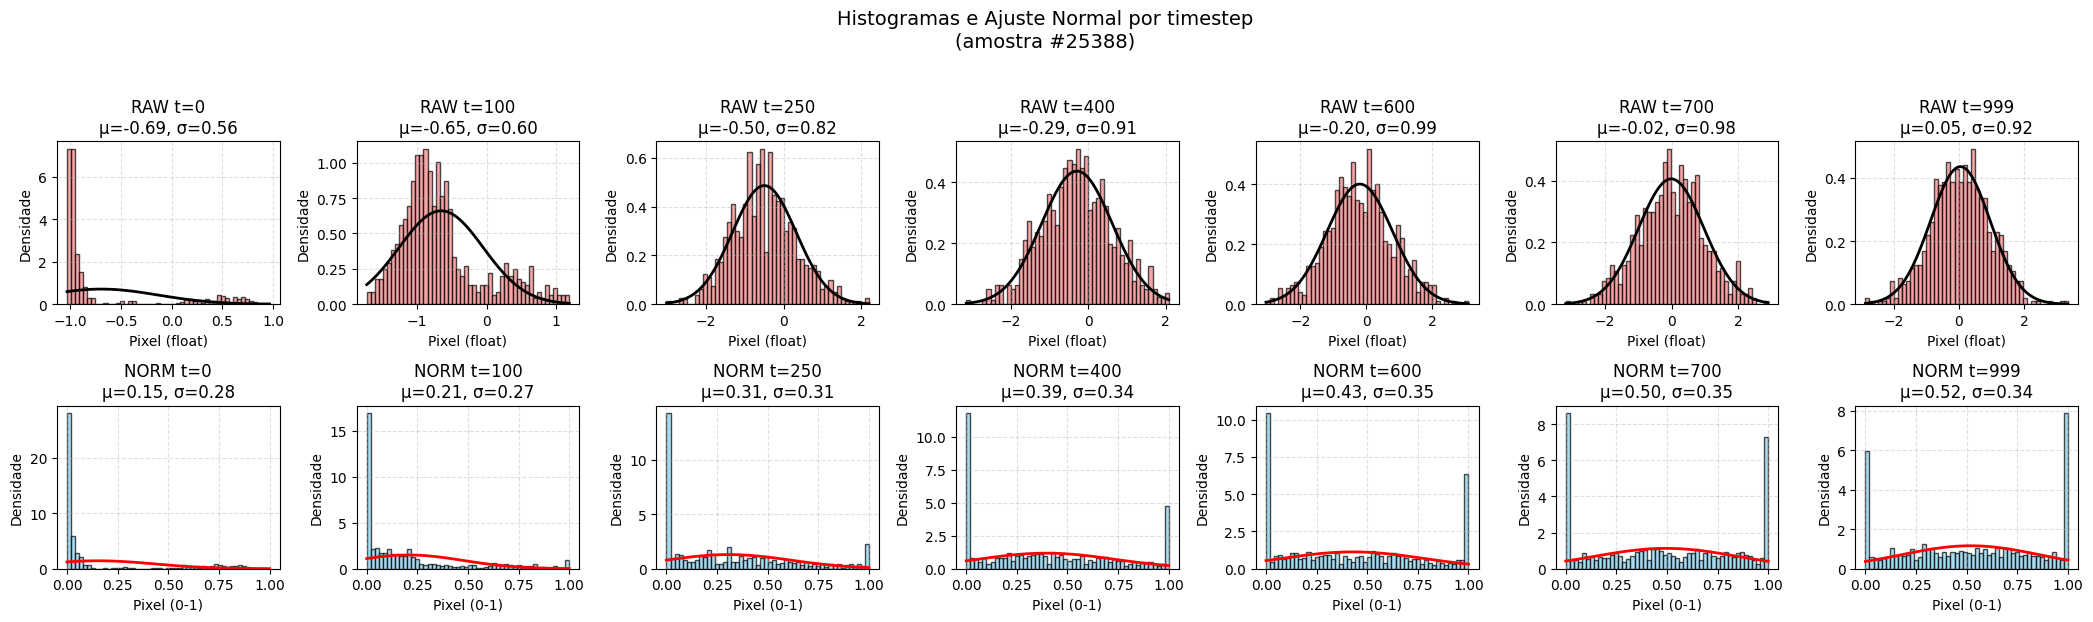

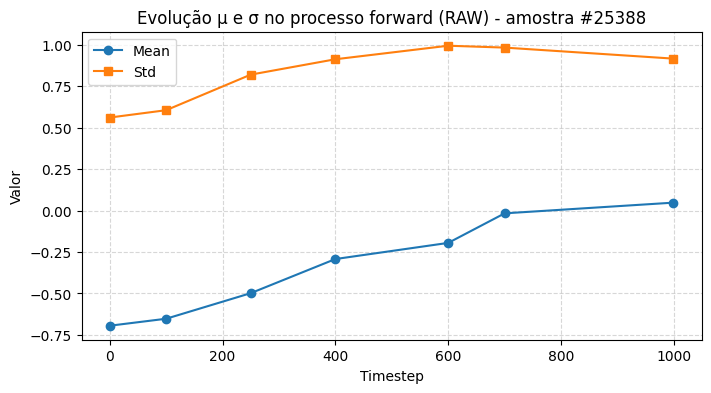

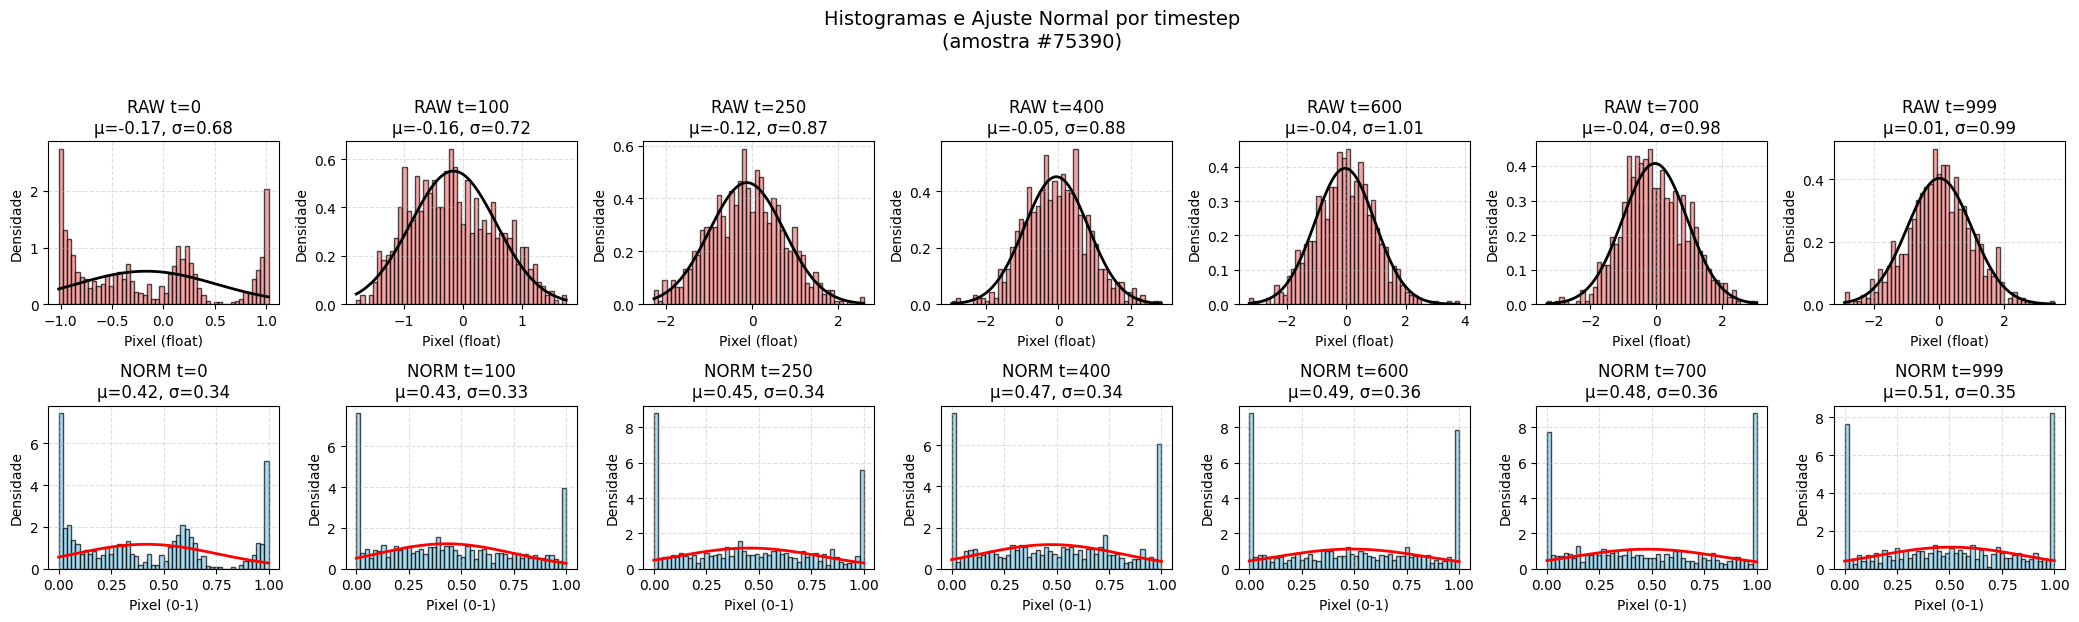

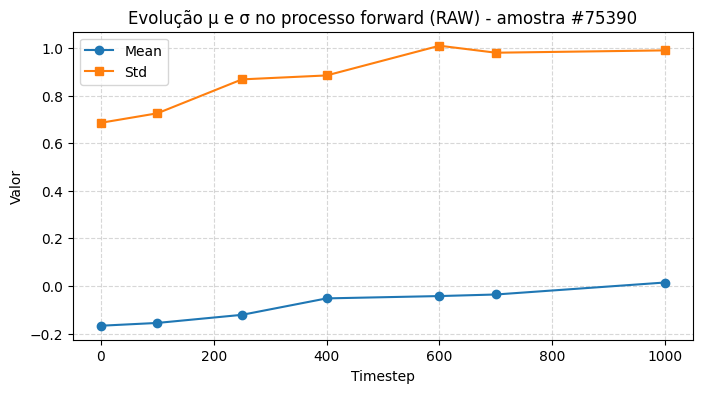

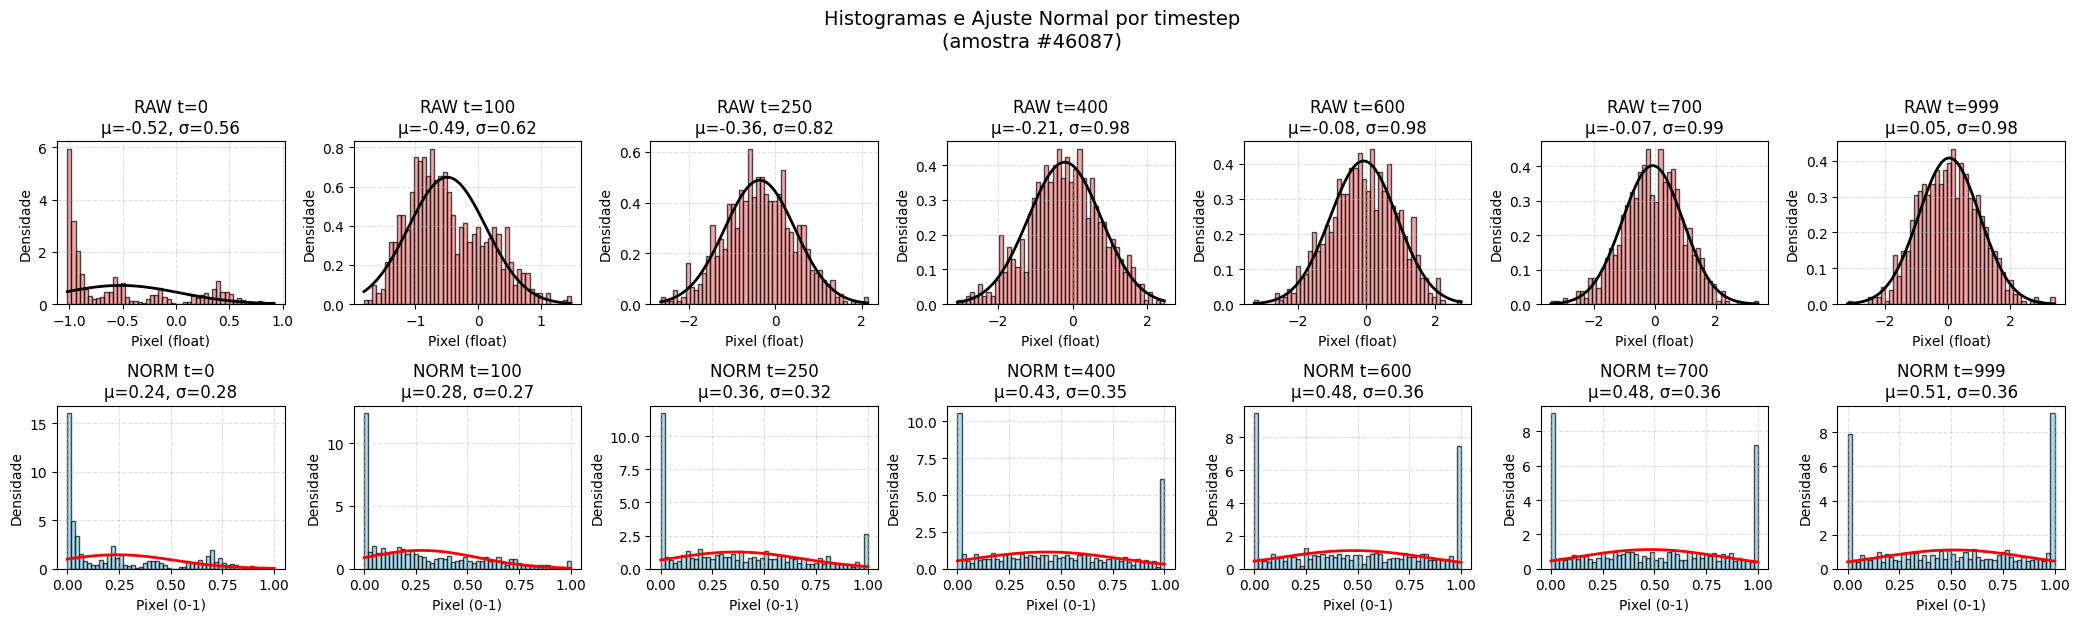

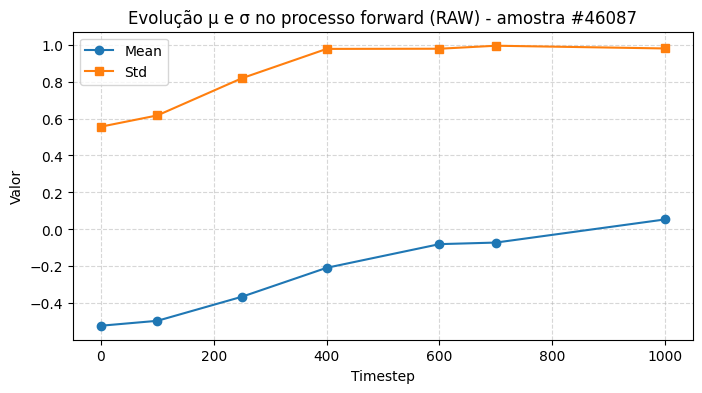

In [ ]:
# Plotar gráficos de cada imagem
plot_list(dataset, indices, pipe, graphs= True)

#### **Executando com $\beta$ schedule consine**

In [ ]:
pipe = DiffusionForward(timesteps=1000, schedule='cosine', device=device)

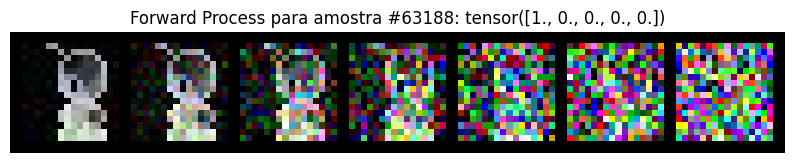

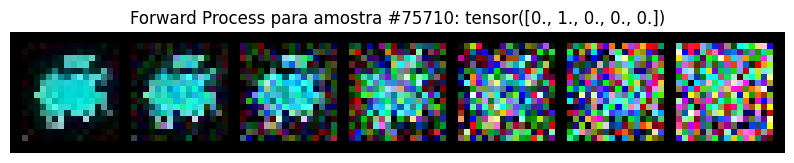

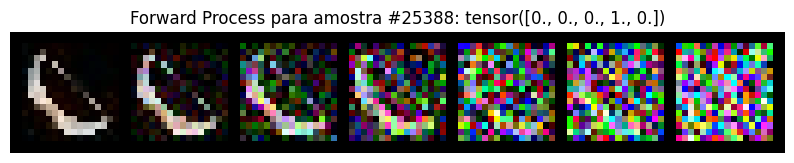

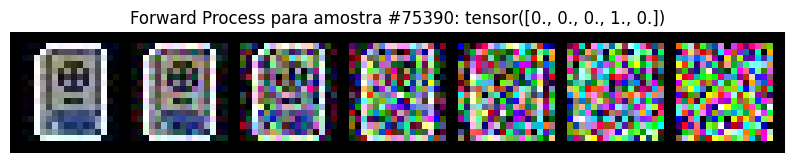

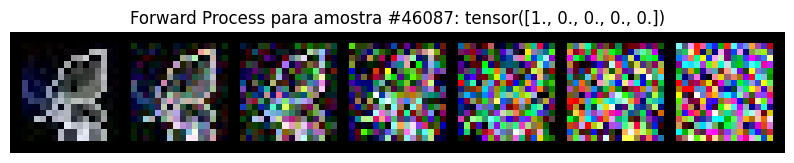

In [ ]:
# Mostrar Forward process de imagens aleatórias
plot_list(dataset, indices, pipe, graphs= False)

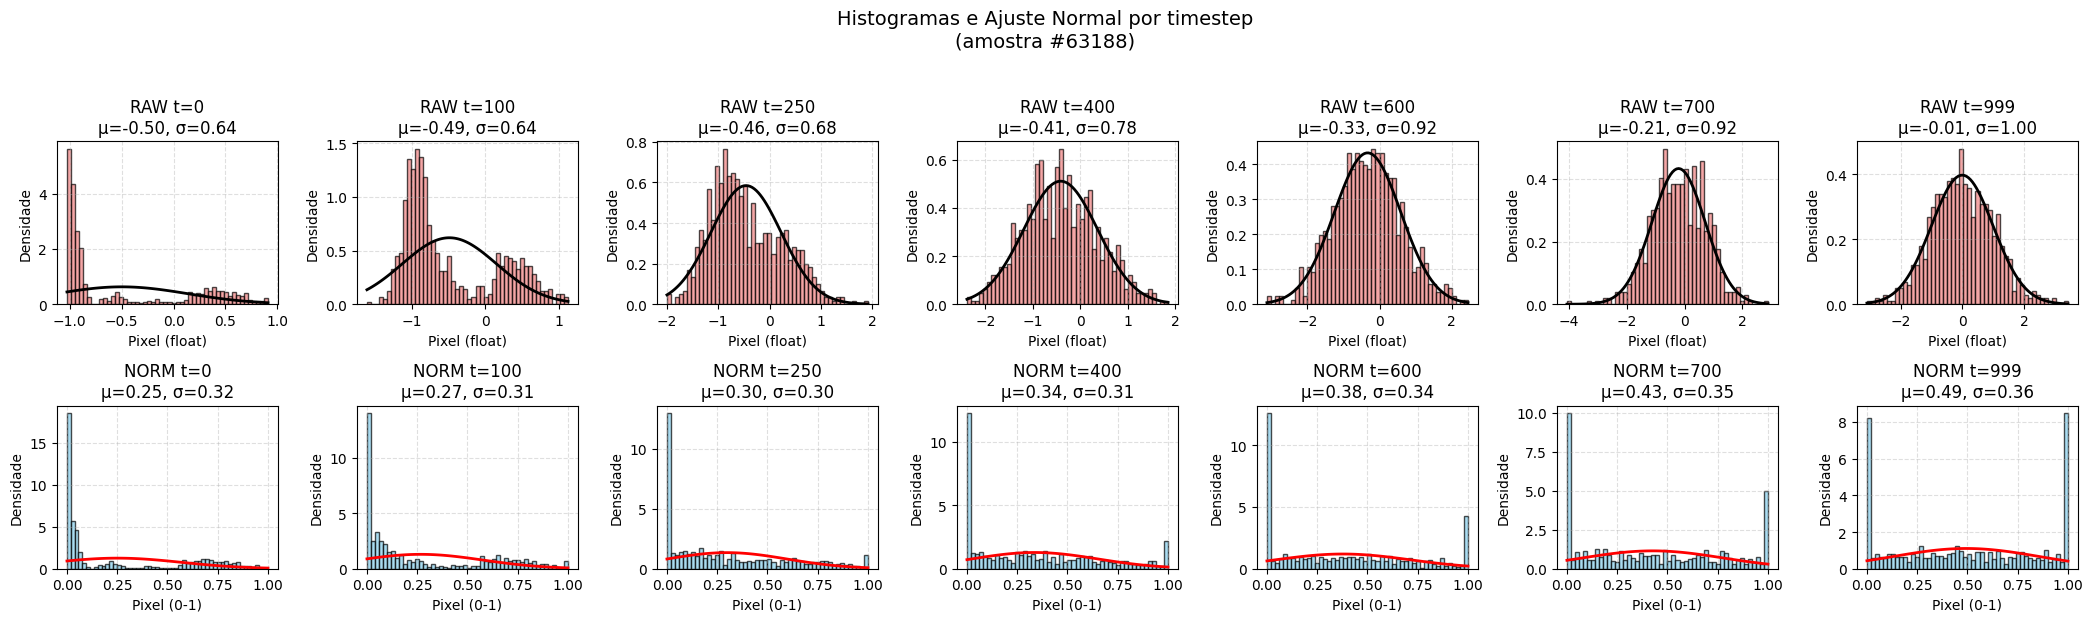

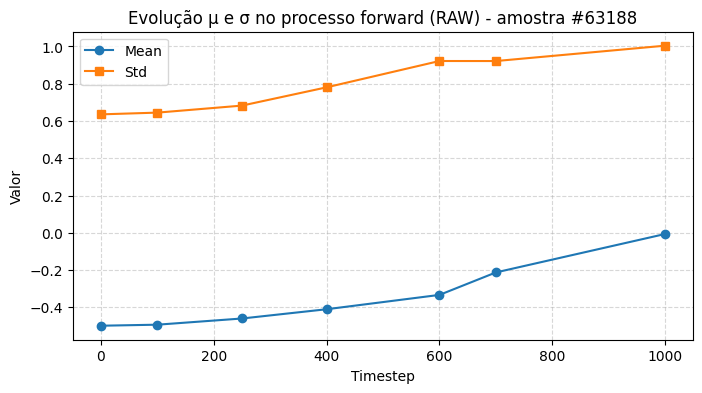

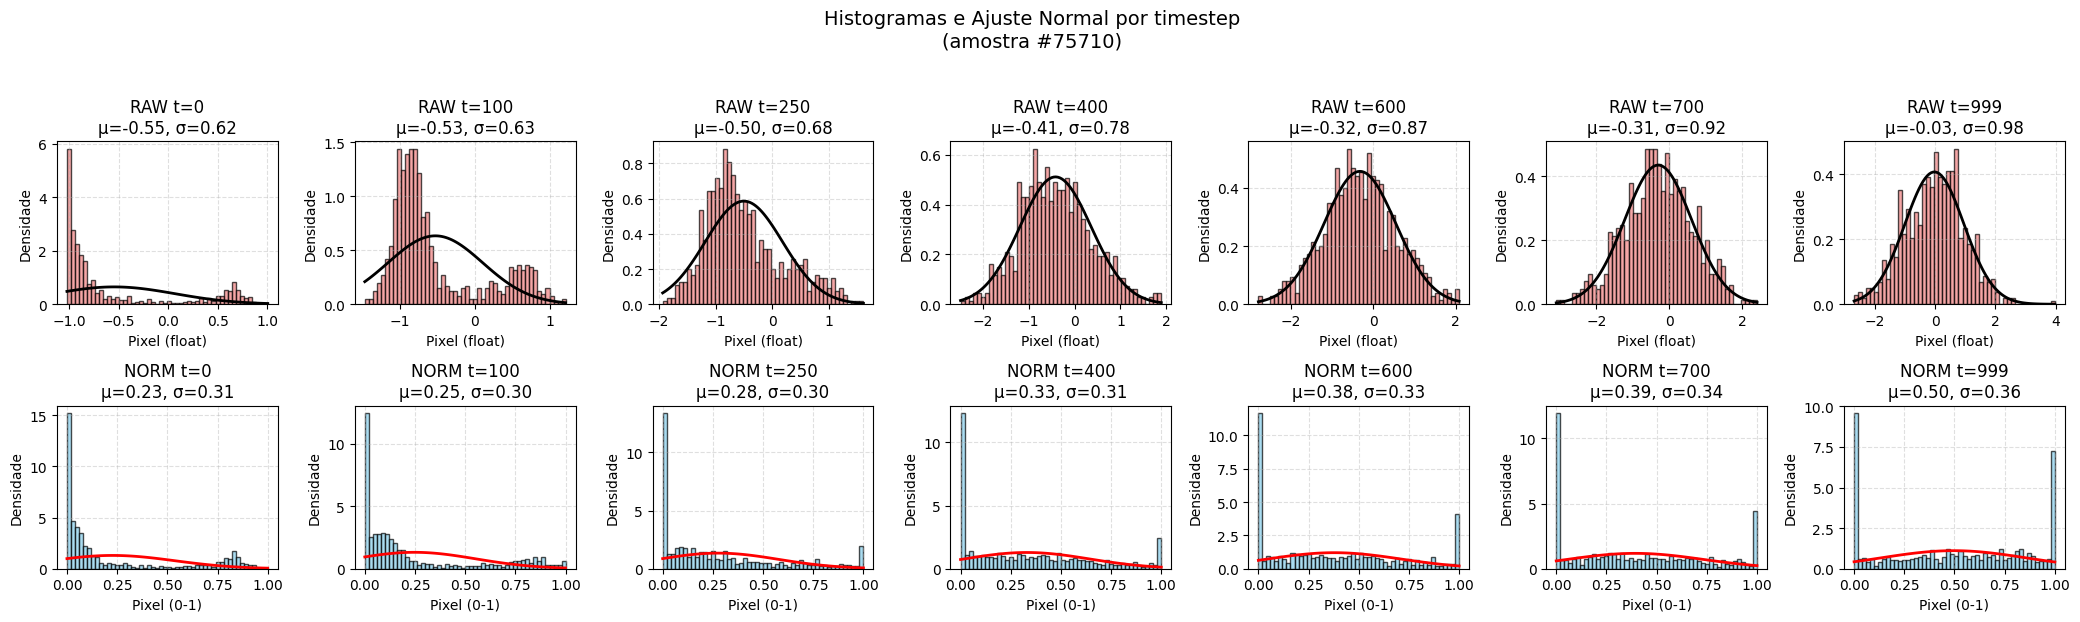

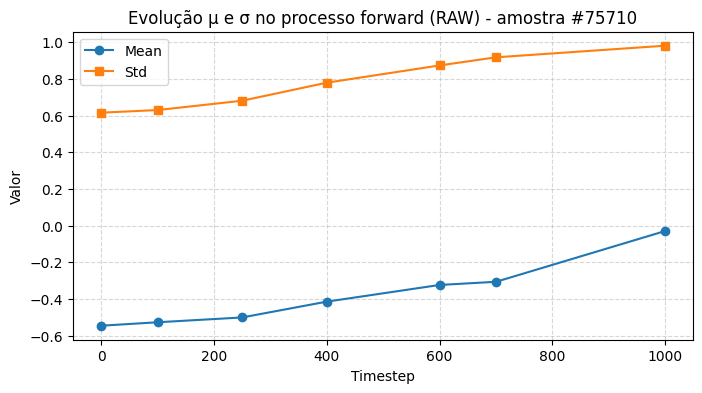

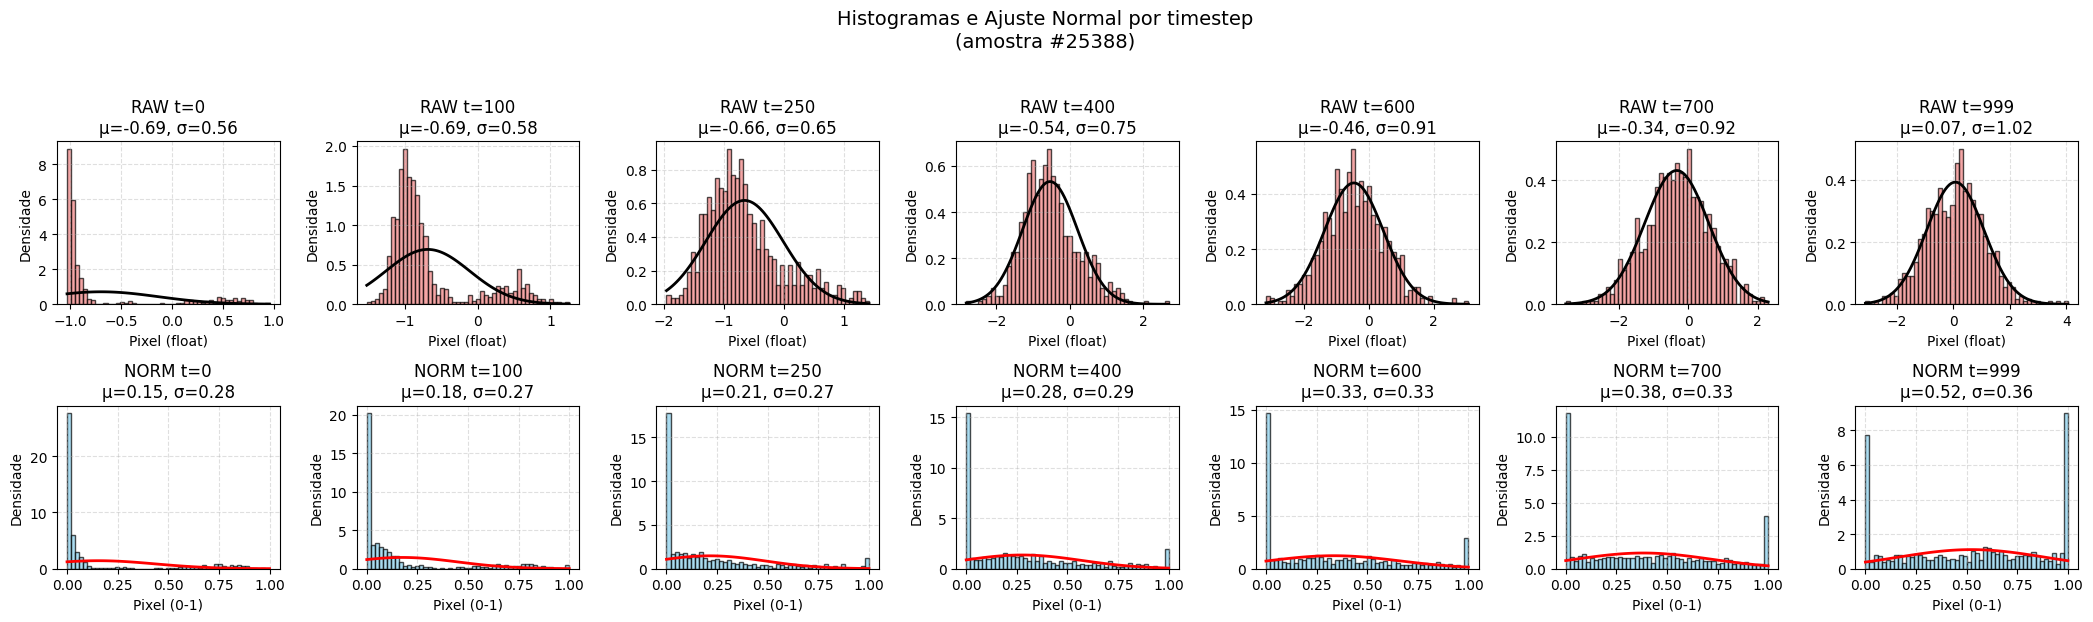

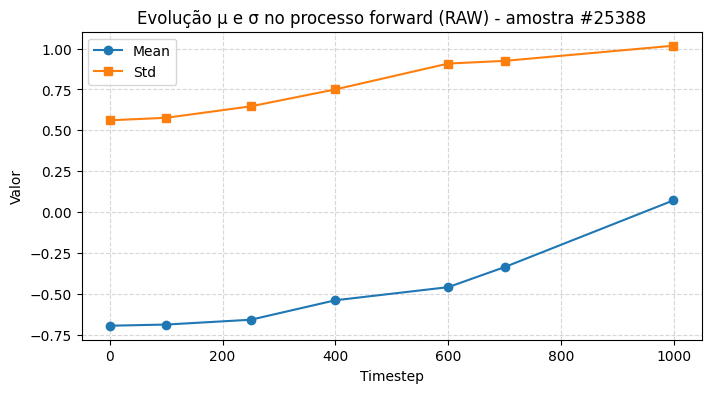

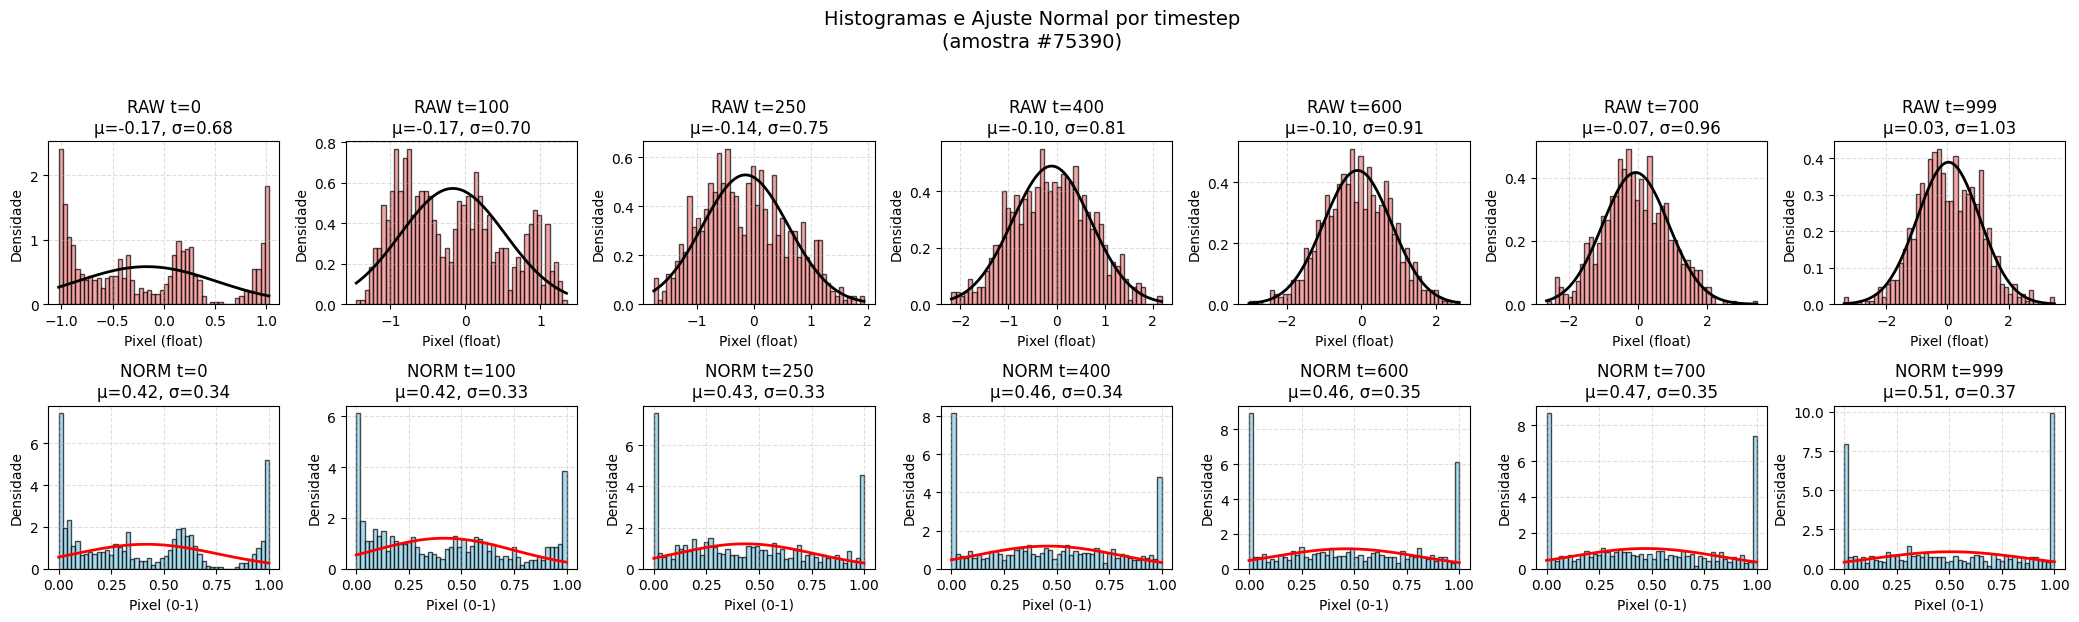

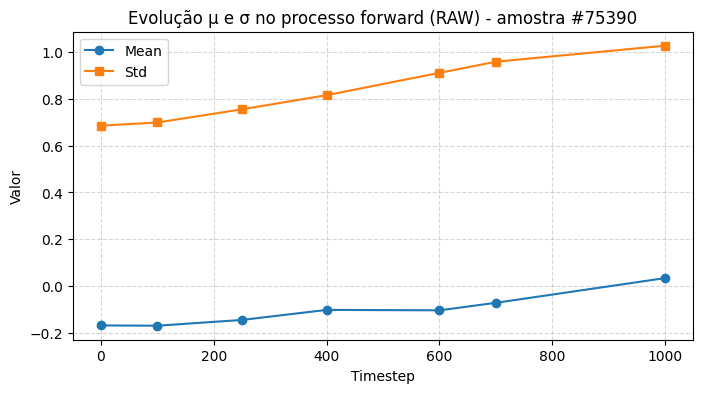

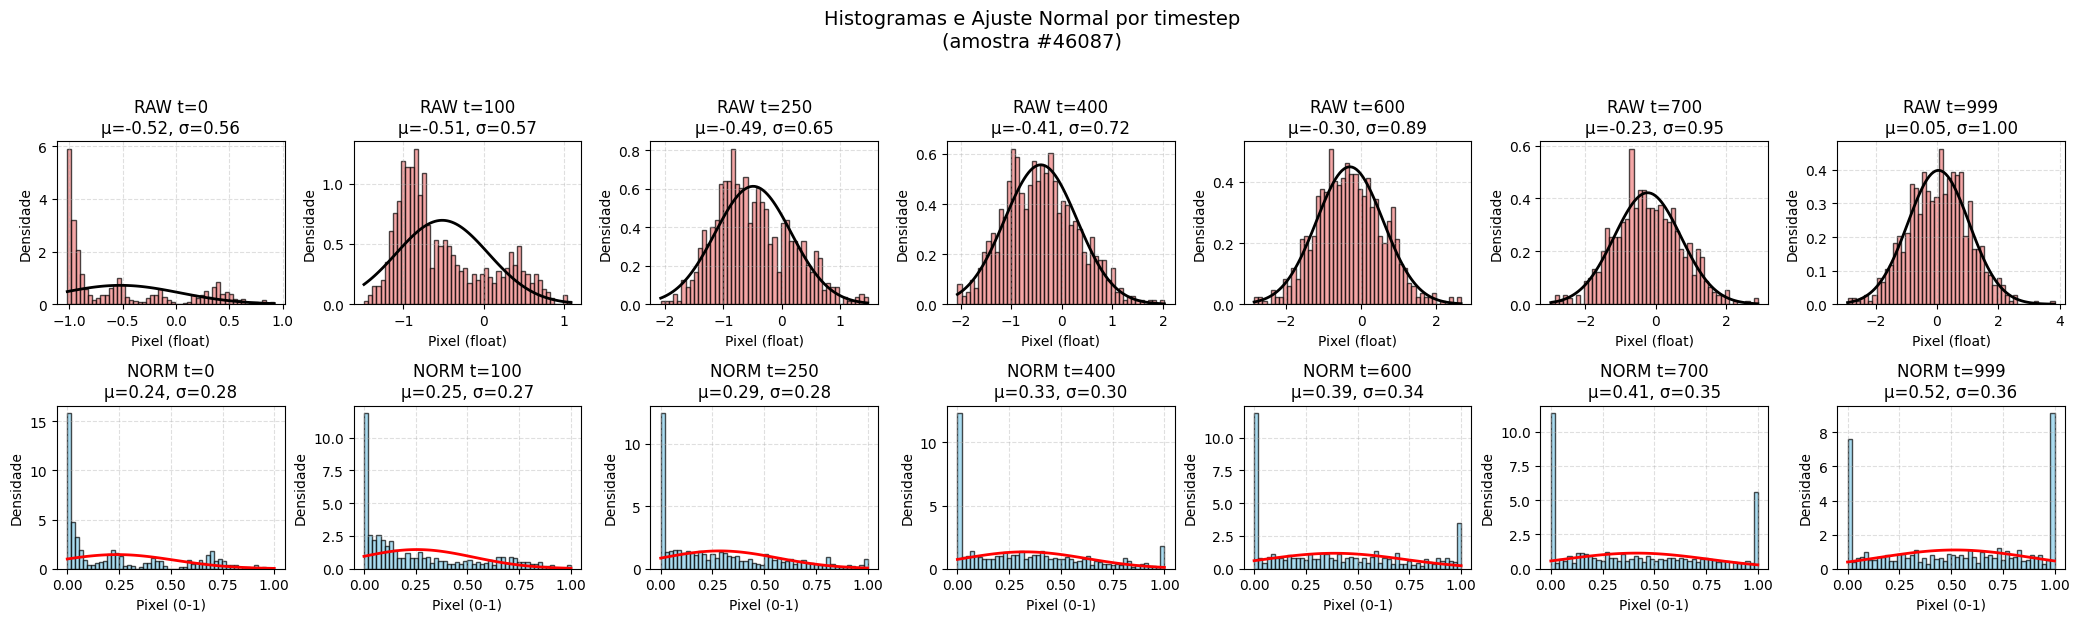

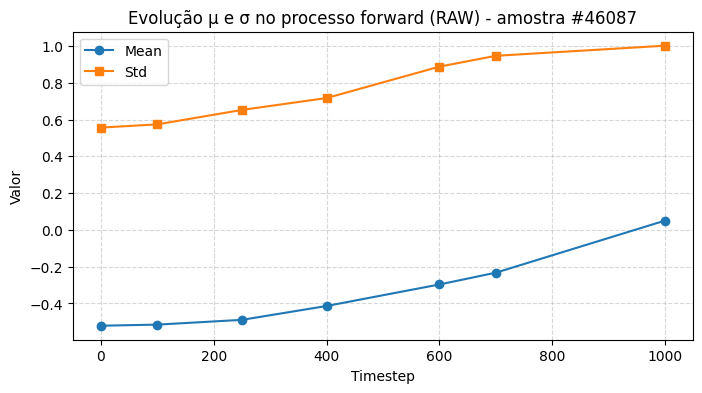

In [ ]:
# Plotar gráficos de cada imagem
plot_list(dataset, indices, pipe, graphs= True)